In [29]:
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import datasets, transforms
from tqdm import tqdm
import torchvision.transforms as transforms
from PIL import Image

class HDF5Dataset(Dataset):
    def __init__(self, file_path, dataset_name, transform=None):
        self.file_path = file_path
        self.dataset_name = dataset_name
        self.transform = transform
        with h5py.File(self.file_path, 'r') as file:
            self.dataset_len = len(file[self.dataset_name])

    def __len__(self):
        return self.dataset_len

    def __getitem__(self, idx):
            with h5py.File(self.file_path, 'r') as file:
                data = file[self.dataset_name][idx]

            # Apply transformations
            if self.transform:
                data = self.transform(data)

            return torch.tensor(data), idx

import matplotlib.pyplot as plt

def plot_image(tensor_img, title=""):
    # Convert the tensor to numpy array and transpose the axes from (C, H, W) to (H, W, C)
    np_img = tensor_img.numpy().transpose(1, 2, 0)
    plt.imshow(np_img)
    plt.title(title)
    plt.axis('off')
    plt.show()


def numpy_to_pil(np_array):
    # Assuming the numpy array is an image with shape (H, W, C)
    return Image.fromarray(np_array.astype('uint8'), 'RGB')

transform = transforms.Compose([
    transforms.Lambda(lambda x: numpy_to_pil(x)),
    transforms.ToTensor(),
])

# Use the custom dataset
hdf5_dataset = HDF5Dataset('/Users/daviddrexlin/Code/Master/data/pcam/camelyonpatch_level_2_split_test_x.h5', 'x', transform=transform)

# Create a DataLoader
loader = DataLoader(hdf5_dataset, batch_size=2048, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

/var/folders/hd/nsfzclkn51531l1nq9cc2x080000gn/T/ipykernel_12038/2807615967.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data), idx


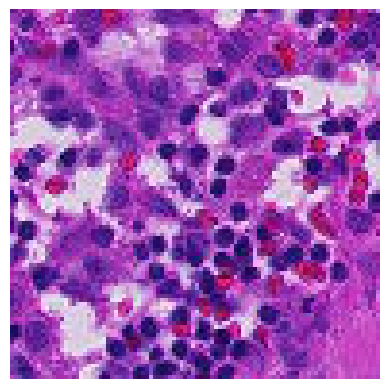

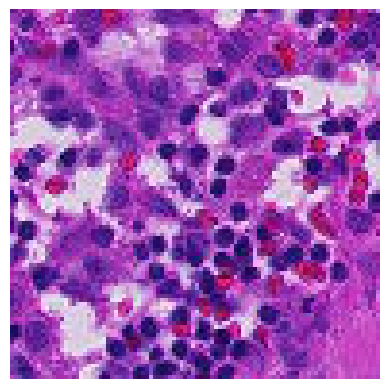

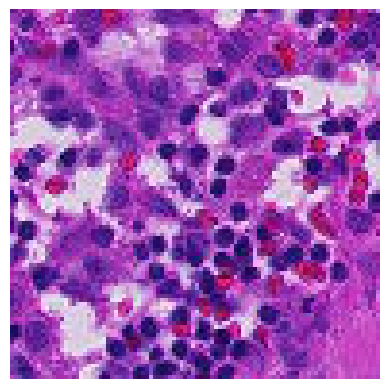

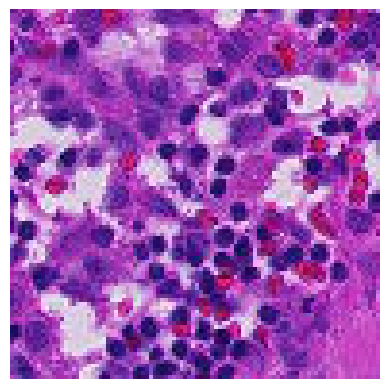

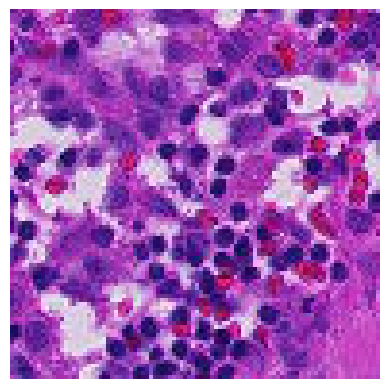

In [30]:
suspects = [(0,1582),(3,936),(9,204),(10,614),(12,2015)]
cache = []
for batch_idx, (data, _) in enumerate(loader):
    for batch_index, batch_indice in suspects: 
        if batch_index == batch_idx: 
            for i, x in enumerate(data):
                if i == batch_indice:
                    cache.append(x)
                    plot_image(x)                    

In [31]:
for i in range(len(cache)):
    for j in range(i + 1, len(cache)):
        print("is identical")
        print(torch.equal(cache[i], cache[j]))

is identical
True
is identical
True
is identical
True
is identical
True
is identical
True
is identical
True
is identical
True
is identical
True
is identical
True
is identical
True


In [33]:
# Create a DataLoader
loader = DataLoader(hdf5_dataset, batch_size=8192, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

def check_duplicates_in_batches(loader):
    batch_duplicate_info = []

    for batch_idx, (data, indices) in enumerate(loader):
        num_images = len(data)
        duplicate_pairs = set()  # To store unique pairs of duplicates

        # Compare each image with every other image in the batch
        for i in range(num_images):
            for j in range(i + 1, num_images):
                if torch.equal(data[i], data[j]):
                    duplicate_pairs.add((indices[i].item(), indices[j].item()))  # Use global indices

        # Compute the number of unique images that have duplicates
        unique_images_with_duplicates = set(idx for pair in duplicate_pairs for idx in pair)

        # Calculate the percentage of images that are duplicates
        if num_images > 0:
            percentage_duplicates = (len(unique_images_with_duplicates) / num_images) * 100
        else:
            percentage_duplicates = 0

        batch_duplicate_info.append({
            "batch_idx": batch_idx,
            "duplicate_pairs": duplicate_pairs,
            "percentage_duplicates": percentage_duplicates
        })

    return batch_duplicate_info

# Example usage
batch_duplicate_info = check_duplicates_in_batches(loader)
for info in batch_duplicate_info:
    print(f"Batch {info['batch_idx']}: {info['percentage_duplicates']:.2f}% duplicates")


/var/folders/hd/nsfzclkn51531l1nq9cc2x080000gn/T/ipykernel_12038/2807615967.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(data), idx


Batch 0: 7.10% duplicates
Batch 1: 7.41% duplicates
Batch 2: 7.31% duplicates
Batch 3: 7.30% duplicates


In [43]:
for info in batch_duplicate_info:
    print(f"Batch {info['batch_idx']}: {info['percentage_duplicates']:.2f}% duplicates")
    print(f"Number of Duplicates: {len(info['duplicate_pairs'])}")

Batch 0: 7.10% duplicates
Number of Duplicates: 429
Batch 1: 7.41% duplicates
Number of Duplicates: 465
Batch 2: 7.31% duplicates
Number of Duplicates: 427
Batch 3: 7.30% duplicates
Number of Duplicates: 444


In [2]:
import cv2
import numpy as np
from skimage import color
import torch
import yaml
from typing import List

class DatasetStatistics:
    def __init__(self, color_space="LAB"):
        assert color_space in ["LAB", "HED", "HSV"], f"Unsupported color space: {color_space}"
        self.color_space = color_space
        self.avg_lists = [[] for _ in range(3)]  # List of lists for L/A/B or H/E/D averages
        self.std_lists = [[] for _ in range(3)]  # List of lists for L/A/B or H/E/D standard deviations

    def process_image(self, img):
        if self.color_space == "LAB":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        elif self.color_space == "HED":
            img = color.rgb2hed(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        elif self.color_space == "HSV":
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        for i in range(3):
            self.avg_lists[i].append(np.mean(img[:, :, i]))
            self.std_lists[i].append(np.std(img[:, :, i]))

    def compute_statistics(self):
        statistics = {}
        for i, (avg, std) in enumerate(zip(self.avg_lists, self.std_lists)):
            avg_mean = np.mean(avg)
            avg_std = np.std(avg)
            std_mean = np.mean(std)
            std_std = np.std(std)

            statistics[self.color_space[i]] = {
                "avg": {"mean": avg_mean, "std": avg_std},
                "std": {"mean": std_mean, "std": std_std}
            }
        return statistics

    def fit_distributions(self, statistics: dict) -> dict:
        for key in statistics:
            for stat in ["avg", "std"]:
                data = statistics[key][stat]
                f = Fitter(data, distributions=["norm", "laplace"])
                f.fit()
                best_fit = list(f.get_best(method="sumsquare_error").keys())[0]
                statistics[key][stat]["distribution"] = best_fit
        return statistics

def process_loader(loader, color_space="LAB"):
    stats = DatasetStatistics(color_space=color_space)
    for batch in loader:
        images, _ = batch  # Assuming the loader returns (images, labels)
        for img in images:
            img_np = img.numpy().transpose(1, 2, 0)  # Convert from PyTorch to NumPy format
            img_np = (img_np * 255).astype(np.uint8)  # Assuming the images were normalized to [0, 1]
            stats.process_image(img_np)
    
    statistics = stats.compute_statistics()
    statistics_with_distributions = stats.fit_distributions(statistics)
    return statistics_with_distributions

# Usage Example:
# loader = ...  # Your PyTorch DataLoader
# stats = process_loader(loader, color_space="LAB")
# print(stats)

ModuleNotFoundError: No module named 'fitter'

In [ ]:
process_loader(loader, color_space="LAB")

NameError: name 'process_loader' is not defined

In [3]:
# Variables to store sum and square sum of pixel values, initialized on the device
mean = torch.zeros(3).to(device)
std = torch.zeros(3).to(device)

# Calculate the sum and square sum
for images in tqdm(loader):
    images = images.to(device)
    mean += images.mean([0, 2, 3])
    print(images.std([0, 2, 3]))
    break
    std += images.std([0, 2, 3])

# Average over the number of batches
mean /= len(loader)
std /= len(loader)

# Move mean and std back to CPU for further processing or printing
mean = mean.cpu()
std = std.cpu()

print(f"Calculated mean: {mean}")
print(f"Calculated std: {std}")

  0%|          | 0/64 [00:00<?, ?it/s]


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Byte

In [2]:
import torch
l = torch.zeros(5)

In [3]:
l.shape

torch.Size([5])